<i>Copyright (c) Microsoft Corporation. All rights reserved.</i>

<i>Licensed under the MIT License.</i>

# Training a Multi-Object Tracking Model

This notebook provides an introduction and a framework for training a multi-object tracking model.

Using [torchvision](https://pytorch.org/docs/stable/torchvision/index.html), and a small dataset, this notebook demonstrates how to train and evaluate a one-shot multi-object tracking model. Specifically, this notebook uses [FairMOT](https://github.com/ifzhang/FairMOT), a state-of-the-art tracking model with high accuracy and fast inference speed. Here, the model trains on a set of still images, and is then evaluated on a video.

For more information regarding FairMOT and multi-object tracking, please visit the [FAQ](./FAQ.md).

## Initialization
Import all the functions we need.

In [1]:
# Ensure edits to libraries are loaded and plotting is shown in the notebook.
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# Regular Python Libraries
import os
import os.path as osp
import sys

# Third party tools
from ipywidgets import Video
import matplotlib.pyplot as plt
import torch
import torchvision

# Computer Vision repository
sys.path.append("../../")
from utils_cv.common.data import data_path, unzip_url
from utils_cv.common.gpu import which_processor, is_windows
from utils_cv.tracking.data import Urls
from utils_cv.tracking.dataset import TrackingDataset
from utils_cv.tracking.model import TrackingLearner
from utils_cv.tracking.plot import play_video, write_video, plot_single_frame

# Change matplotlib backend so that plots are shown for windows
if is_windows():
    plt.switch_backend("TkAgg")

print(f"TorchVision: {torchvision.__version__}")
which_processor()

TorchVision: 0.4.0a0
Torch is using GPU: Tesla K80


The above torchvision command displays your machine's GPUs (if it has any) and the compute that `torch/torchvision` is using.

Next, set some training and inference parameters, as well as the data input parameters.

In [3]:
# training params
EPOCHS = 5
LEARNING_RATE = 0.0001
BATCH_SIZE = 4
MODEL_PATH = ("./models/all_dla34.pth")  # the path of the pretrained model to finetune/train
TRAINED_MODEL_PATH = "./models/all_dla34_ft0701.pth"  # the path of the pretrained model to finetune/train

# inference params
CONF_THRES = 0.3
TRACK_BUFFER = 300

# data
TRAIN_DATA_PATH = unzip_url(Urls.cans_path, exist_ok=True)
EVAL_DATA_PATH = unzip_url(Urls.carcans_annotations_path, exist_ok=True)

# train on the GPU or on the CPU, if a GPU is not available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Using torch device: {device}")

Using torch device: cuda


## Setup

Please make sure to follow the setup instructions in the [README.md](https://github.com/microsoft/computervision-recipes/blob/master/scenarios/tracking/README.md) file to install all required imports. 

In addition, to be able to run this notebook, the baseline FairMOT model needs to be downloaded [here](https://drive.google.com/file/d/1udpOPum8fJdoEQm6n0jsIgMMViOMFinu/view) and saved to the `./models` folder as `all_dla.pth`.

## Prepare Training Dataset

This section will show how to use a small training dataset to finetune a pre-trained model. The training dataset, contains 12 images of cans across four classes `{coke, gingerale, espresso, coldbrew}`. These photos have been taken against differing backgrounds to provide additional contrast. 

Note that we use different cans for training, so that the re-id component in the FairMOT tracker can learn to distinguish different type of cans from one-another. During inference time, this will enable the tracker to distinguish between cans it had not seen during training. 

In [4]:
os.listdir(TRAIN_DATA_PATH)

['images', 'annotations', 'labels_with_ids', 'default.train']

Within this data folder there are now two different subfolders:
- `/images/`
- `/annotations/`

This format, one folder for images and one folder for labels, is fairly common for object detection and object tracking. In fact, the annotation format (Pascal VOC) is identical to the annotation format used for object detection - see the [01_training_introduction.ipynb](../detection/01_training_introduction.ipynb) notebook for more information.

## Load Training Images

To load the data, we use the `TrackingDataset` class. This object knows how to read images and annotations consistent with the  format specified above.

In [5]:
data_train = TrackingDataset(TRAIN_DATA_PATH, batch_size=BATCH_SIZE)
print("Found {} training images.".format(len(data_train.im_filenames)))

Found 12 training images.


In [6]:
data_train.show_ims()

## Finetune a Pretrained Model

For the TrackingLearner, we use FairMOT's baseline tracking model. FairMOT's baseline tracking model is pre-trained on pedestrian datasets, such as the [MOT challenge datasets](https://motchallenge.net/). Therefore, it does not yet detect fridge objects, like those used in the evaulation video.

When we initialize the TrackingLearner, we can pass in the training dataset and the path to which the trained 
model will be saved. By default, we use the baseline FairMOT model in `./models/all_dla.pth`.  

In [7]:
tracker = TrackingLearner(data_train, MODEL_PATH)

To run the training, we call the `fit` method in the tracker object.

In [8]:
tracker.fit(num_epochs=EPOCHS, lr=LEARNING_RATE)

loaded ./models/all_dla34.pth, epoch 10
=====  Epoch: 1/5  =====


/anaconda/envs/cv/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


loss: 11.726488987604776
hm_loss: 2.867958943049113
wh_loss: 3.4438455171055264
off_loss: 0.2181321465306812
id_loss: 1.5872375236617193
time:1.3666666666666667 min
=====  Epoch: 2/5  =====
loss: 3.3320106665293374
hm_loss: 0.4691260854403178
wh_loss: 1.5539637274212308
off_loss: 0.19172420766618517
id_loss: 1.530221700668335
time:1.3333333333333333 min
=====  Epoch: 3/5  =====
loss: 2.2733108599980674
hm_loss: 0.1843376588076353
wh_loss: 1.290913035472234
off_loss: 0.18711607075399822
id_loss: 1.4918706350856357
time:1.3333333333333333 min
=====  Epoch: 4/5  =====
loss: 2.0464919673071966
hm_loss: 0.1308591345118152
wh_loss: 1.2699358661969502
off_loss: 0.18778282735082838
id_loss: 1.4553289612134297
time:1.3333333333333333 min
=====  Epoch: 5/5  =====
loss: 1.7739911609225802
hm_loss: 0.09972425581266482
wh_loss: 1.0527717603577509
off_loss: 0.16333779609865612
id_loss: 1.4366384545962017
time:1.3333333333333333 min


The function below, visualizes the training losses computed in each training epoch, and shows how the model improves with training. We want to run the training for an appropriate `num_epochs` and `lr` (to be fine-tuned by the user) that produces a loss-curve that tails off. The loss-curve for our training is as follows:

In [9]:
tracker.plot_training_losses()

# Predict and Evaluate Tracking
To validate the trained model, we want to run it on an evaluation dataset and compare the predicted tracking results with the dataset's ground-truth annotations.

For an evaluation dataset, we will be using the following video. We annotated and stored each frame in the `EVAL_DATA_PATH`. For more details on how to prepare the annotation and evaluation dataset in the correct format, please see the  [FAQ](./FAQ.md). 

In [10]:
eval_video = osp.join(EVAL_DATA_PATH, "car_cans_1s.mp4")
#Video.from_file(eval_video)

This shows a single frame from the middle of the video:

In [22]:
plot_single_frame({15:None}, eval_video, 15)

TypeError: 'NoneType' object is not iterable

## Predict

Now, we can run the `predict` function on our evaluation dataset. Note that there are several parameters that can be tweaked to improve the tracking performance and inference speed, including `conf_thres` and `track_buffer`. Please see the  [FAQ](./FAQ.md) for more details.  

In [11]:
eval_results = tracker.predict(
    EVAL_DATA_PATH, conf_thres=CONF_THRES, track_buffer=TRACK_BUFFER,
)

The call to `predict` returns the dictionary `eval_results` where each key is the frame number, and the value is a list of `TrackingBbox` objects that represent the tracking information of each object detected. For example, when we print out the tracking results from the last frame (frame 30), we can see two objects being tracked:

In [12]:
print("Last frame...tracking result:", eval_results[max(eval_results.keys())])

Last frame...tracking result: [{Bbox object: [left=625, top=263, right=731, bottom=426] | frame: 30 | track: 1}, {Bbox object: [left=875, top=208, right=957, bottom=341] | frame: 30 | track: 2}]


## Evaluate

We can simply pass on our `tracking_results` to the `evaluate` method in the tracker object to evaluate the results. Additionally, we supply the path of the ground-truth data. The output results are shown via standard MOT metrics, e.g. MOTA, IDF1. Please refer to the [FAQ](./FAQ.md) for more details on MOT metrics.

In [13]:
eval_metrics = tracker.evaluate(eval_results, EVAL_DATA_PATH)
print(eval_metrics)

            IDF1   IDP   IDR  Rcll  Prcn GT MT PT ML FP FN IDs  FM MOTA  MOTP IDt IDa IDm
single_vid 46.8% 53.1% 41.3% 39.7% 52.1%  2  0  2  0 23 38   0  13 3.2% 0.346   0   0   0
OVERALL    46.8% 53.1% 41.3% 39.7% 52.1%  2  0  2  0 23 38   0  13 3.2% 0.346   0   0   0


## Visualize results

We can visualize the tracking results by overlaying the bounding boxes and ids of the tracked objects onto the video and writing it to the folling file:

In [20]:
results_video_path = osp.join(data_path(), "01_evalvid_tracked.mp4")
write_video(eval_results, eval_video, results_video_path)

Output saved to /home/pabuehle/Desktop/computervision-recipes/data/01_evalvid_tracked.mp4.


The following cell extracts and displays certtain frames from this video.

[{Bbox object: [left=1184, top=269, right=1314, bottom=465] | frame: 1 | track: 1}, {Bbox object: [left=542, top=204, right=625, bottom=325] | frame: 1 | track: 2}]


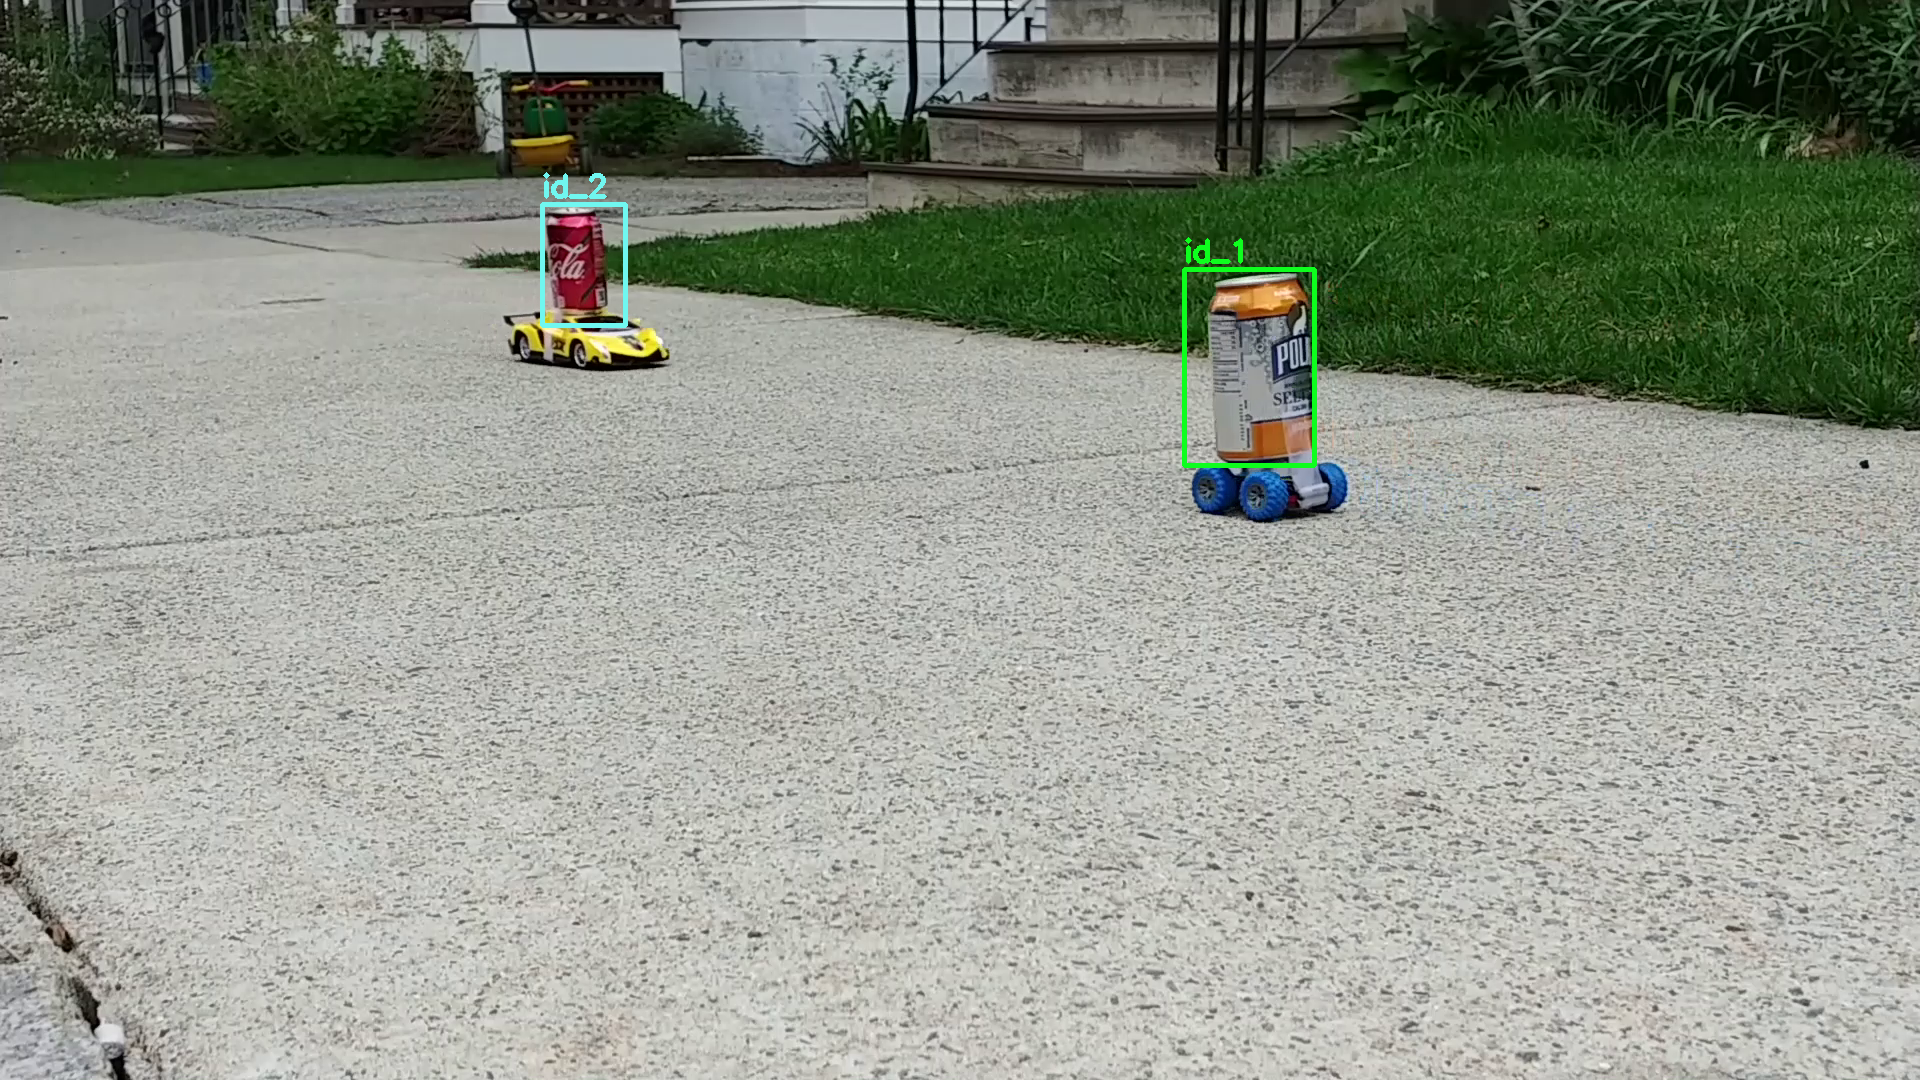

[{Bbox object: [left=923, top=269, right=1045, bottom=458] | frame: 16 | track: 1}, {Bbox object: [left=718, top=205, right=796, bottom=329] | frame: 16 | track: 2}]


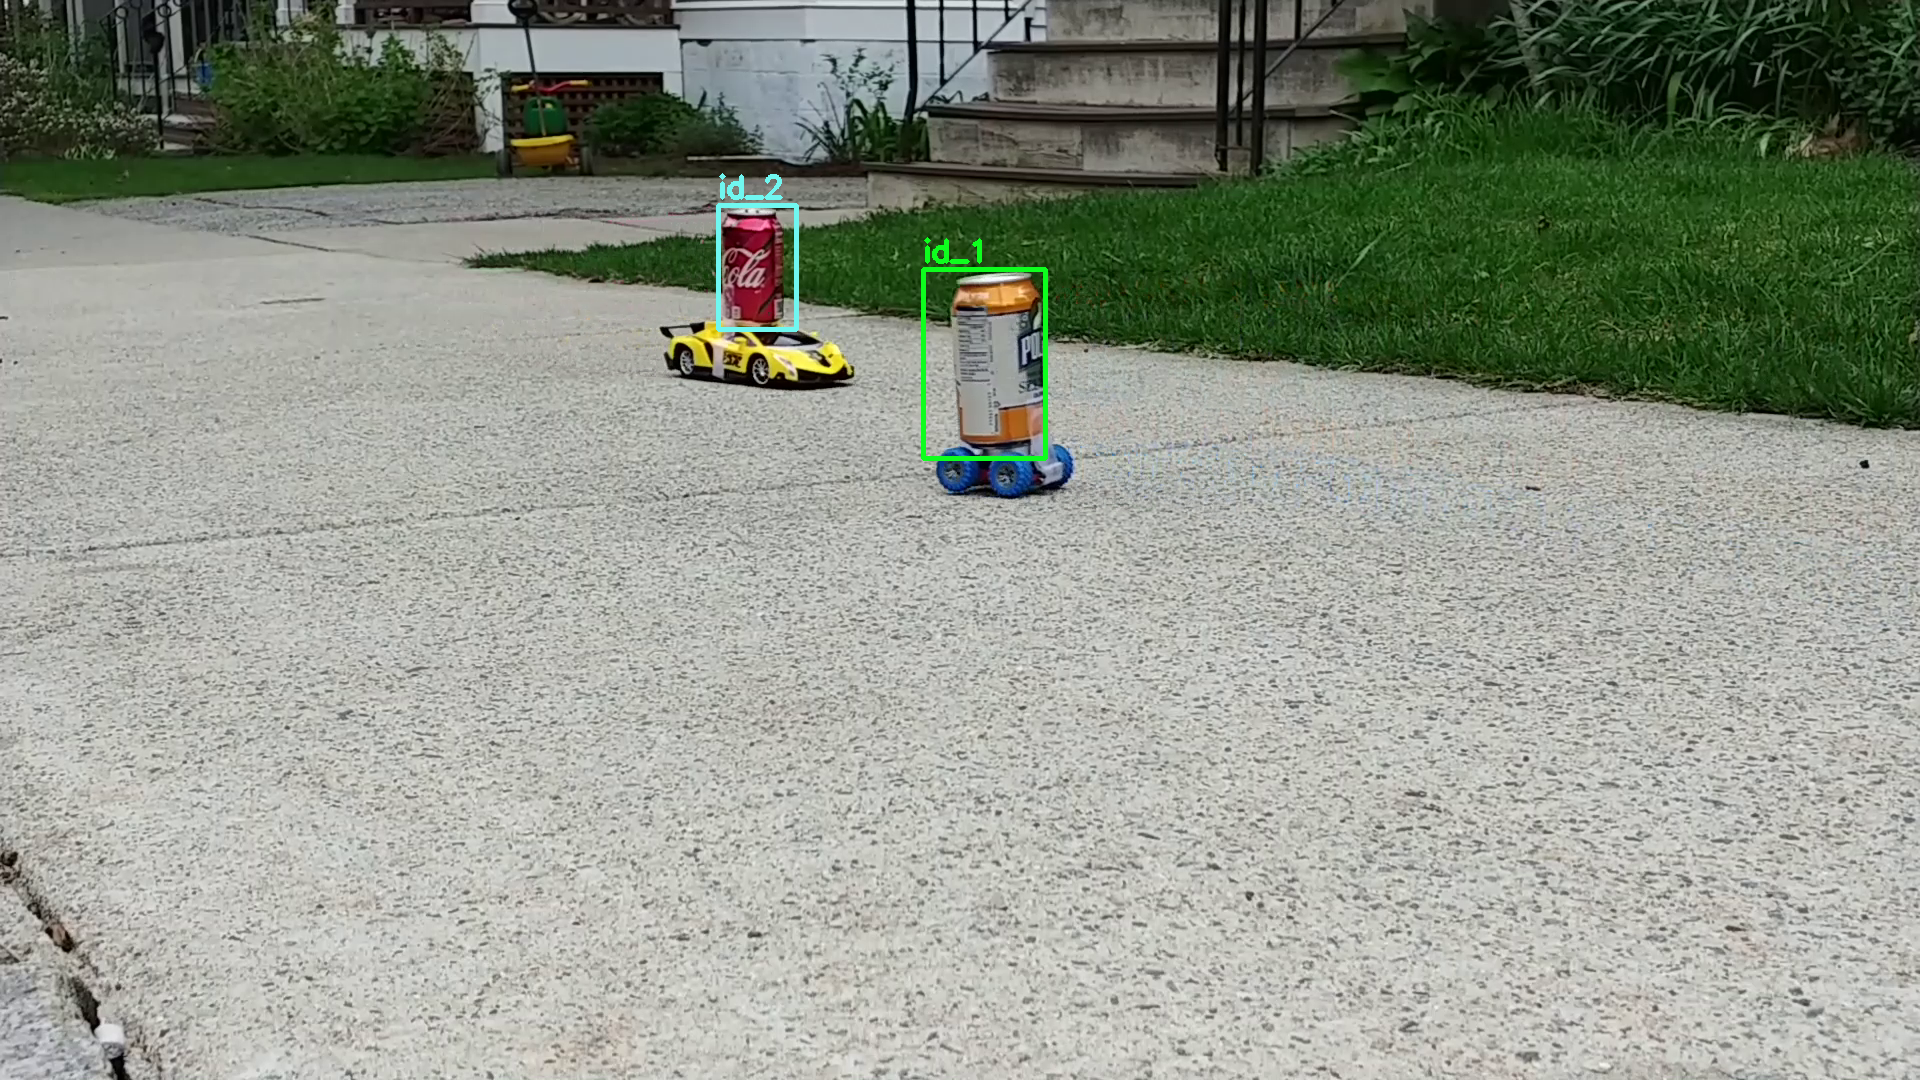

[{Bbox object: [left=625, top=263, right=731, bottom=426] | frame: 30 | track: 1}, {Bbox object: [left=875, top=208, right=957, bottom=341] | frame: 30 | track: 2}]


error: OpenCV(3.4.2) /tmp/build/80754af9/opencv-suite_1535558553474/work/modules/imgproc/src/color.hpp:253: error: (-215:Assertion failed) VScn::contains(scn) && VDcn::contains(dcn) && VDepth::contains(depth) in function 'CvtHelper'


In [21]:
for frame_i in [1, int(len(eval_results) / 2 + 1), len(eval_results) - 1]:
    print(eval_results[frame_i])
    im = plot_single_frame(eval_results, eval_video, frame_i)

In addition, we can play the video here in the notebook:

In [19]:
Video.from_file(results_video_path)
#play_video(eval_results, eval_video)

NameError: name 'results_video_path' is not defined

## Save the trained model
If satified with the results from evalutation, we can save this finetuned model to disk for later use. 
```
tracker.save(TRAINED_MODEL_PATH)
```

To load the model and track objects in a new video these commands can be used
```
tracker = TrackingLearner(None, TRAINED_MODEL_PATH)
test_results = tracker.predict(
    path_to_video, conf_thres=CONF_THRES, track_buffer=TRACK_BUFFER,
)
```